##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [148]:
# import libraries
import re
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [149]:
# Ignore warnings because there seem to be a lot from numpy stuff
warnings.filterwarnings('ignore')

In [150]:
# read data from csv file
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

### Text Preprocessing

In [151]:
def preprocess(text: str) -> str:
    replacements = {
        # Replace links wih URL
        r'(http\S+)': 'URL',

        # Replace @'s with USERNAME
        r'@[A-Za-z0-9]+': 'USERNAME',

        # Replace characters repeated more than with two of the characters
        r'([a-zA-Z])(\1{2,})': '\\1\\1',

        # Remove incorrectly encoded emojis.
        r'...': '',

        '[0-9]+': '',
    }
    for original, replace in replacements.items():
        text = re.sub(original, replace, text)
    return text


# data cleaning

x_test_raw = test_data['text'].apply(preprocess)
x_test_raw = x_test_raw.apply(preprocess)

#check the result
print("test length:", len(x_test_raw))

test length: 6099


In [152]:
# separating instance and label for Train
x_train_raw = train_data.text
y_train_raw = train_data.sentiment

### Training test splitting

In [153]:
# hold out with test size 0.3
x_train, x_test, y_train, y_test = train_test_split(x_train_raw, y_train_raw,
                                                    test_size=0.3,
                                                    random_state=30)

In [154]:
# BoW applied on testing data, training data and develop data
bow_vectorizer = CountVectorizer()
x_train_bow_raw = bow_vectorizer.fit_transform(x_train_raw)
x_test_bow_raw = bow_vectorizer.transform(x_test_raw)
x_train_bow = bow_vectorizer.fit_transform(x_train)
x_test_bow = bow_vectorizer.transform(x_test)

In [155]:
# fit into linear models
models = [DummyClassifier(strategy='most_frequent'),
          MultinomialNB(),
          LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(max_iter=1000)]

for model in models:
    start = time.time()
    model.fit(x_train_bow, y_train)
    end = time.time()
    t = end - start
    acc = model.score(x_test_bow, y_test)
    print(f"Accuracy:{acc} Time: {t}")

Accuracy:0.5882892524078887 Time: 0.00983285903930664
Accuracy:0.6595321816236049 Time: 0.04944157600402832
Accuracy:0.6280385262192325 Time: 2.365900993347168
Accuracy:0.5730010701727565 Time: 6.826035976409912
Accuracy:0.5442592875707079 Time: 0.01828479766845703
Accuracy:0.6619782907812262 Time: 7.975731134414673


### Feature selecting

In [156]:
# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tf_x_train = tfidf_vectorizer.fit_transform(x_train)
tf_x_test = tfidf_vectorizer.transform(x_test)

In [157]:

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(tf_x_train, y_train)
    print(
        f"accuracy for C={c}: {accuracy_score(y_test, lr.predict(tf_x_test))}")

accuracy for C=0.01: 0.5882892524078887
accuracy for C=0.05: 0.6051062528665342
accuracy for C=0.25: 0.6509707995719309
accuracy for C=0.5: 0.6667176272741171
accuracy for C=1: 0.6758905366151965


In [158]:
print(MultinomialNB().fit(tf_x_train, y_train).score(tf_x_test, y_test))

0.5966977526372115


In [159]:

clf = LinearSVC(random_state=0)
clf.fit(tf_x_train, y_train)
print(clf.score(tf_x_test, y_test))


0.663812872649442


In [160]:
tfidf_vectorizer = TfidfVectorizer()
tf_x_train_raw = tfidf_vectorizer.fit_transform(x_train_raw)
tf_x_test_raw = tfidf_vectorizer.transform(x_test_raw)

In [161]:
model_lr = LogisticRegression(multi_class='ovr')
model_lr.fit(tf_x_train_raw, y_train_raw)

prediction = model_lr.predict(tf_x_test_raw)
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data.id)
pre.index.name = 'id'
pre.to_csv(r"tfidf_prediction_cv.csv")

In [162]:
# apply k best on tfidf
kbest = SelectKBest(chi2, k=500).fit(tf_x_train, y_train)
kbest_train_x = kbest.transform(tf_x_train)
kbest_test_x = kbest.transform(tf_x_test)

mnb = MultinomialNB().fit(kbest_train_x, y_train)
print(mnb.score(kbest_test_x, y_test))

clf = LinearSVC(random_state=0)
clf.fit(kbest_train_x, y_train)
print(clf.score(kbest_test_x, y_test))

final_tfidf = LogisticRegression(C=1, max_iter=1000)
final_tfidf.fit(kbest_train_x, y_train)
print(final_tfidf.score(kbest_test_x, y_test))

0.6104571166488304
0.672374254701116
0.6658003363400091


In [163]:
# save the created vocabulary for the given dataset in a separate file
vocab_dict = bow_vectorizer.vocabulary_
output_pd = pd.DataFrame(list(vocab_dict.items()), columns=['word', 'count'])
output_pd.T.to_csv('BoW-vocab.csv', index=False)

In [164]:
# apply k best on BoW 
kbest = SelectKBest(chi2, k=500).fit(x_train_bow_raw, y_train_raw)
kbest_train_x_500 = kbest.transform(x_train_bow_raw)
kbest_test_x_500 = kbest.transform(x_test_bow_raw)

# training dataset
kbest = SelectKBest(chi2, k=700).fit(x_train_bow, y_train)
kbest_train_x_700 = kbest.transform(x_train_bow)
kbest_test_x_700 = kbest.transform(x_test_bow)

train_tuple = (kbest_train_x_700, y_train)
test_tuple = (kbest_test_x_700, y_test)

### Model Adapting

In [165]:
# Use 20 fold cross validation with models
models = [LinearSVC(max_iter=5000),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(max_iter=1000)]

for model in models:
    start = time.time()
    acc = np.mean(cross_val_score(model, *train_tuple, cv=20))
    end = time.time()
    t = end - start
    print(f"{model} train accuracy: {acc} time: {t}")

    start = time.time()
    acc = np.mean(cross_val_score(model, *test_tuple, cv=20))
    end = time.time()
    t = end - start
    print(f"{model} test accuracy: {acc} time: {t}")

LinearSVC(max_iter=5000) train accuracy: 0.6842936225837662 time: 82.16315698623657
LinearSVC(max_iter=5000) test accuracy: 0.6606017378981128 time: 15.616106033325195
DecisionTreeClassifier() train accuracy: 0.5606424934640748 time: 28.13070297241211
DecisionTreeClassifier() test accuracy: 0.5412023569776984 time: 7.20619010925293
KNeighborsClassifier() train accuracy: 0.5794503475534025 time: 8.285599946975708
KNeighborsClassifier() test accuracy: 0.578353192362199 time: 1.7993159294128418
LogisticRegression(max_iter=1000) train accuracy: 0.6835069098968661 time: 23.7684109210968
LogisticRegression(max_iter=1000) test accuracy: 0.6616734728127097 time: 8.893524885177612


# Parameter Tuning

In [166]:
# Graphing helper to graph SVC accuracies for different values of C.
def val_curve(param_range, train_scores, valid_scores, model):
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    mean_valid_scores = np.mean(valid_scores, axis=1)
    std_valid_scores = np.std(valid_scores, axis=1)
    plt.semilogx(param_range,
                 mean_train_scores,
                 label="Training score",
                 color='red')
    plt.fill_between(param_range,
                     mean_train_scores - std_train_scores,
                     mean_train_scores + std_train_scores,
                     alpha=0.2,
                     color="red")

    plt.semilogx(param_range,
                 mean_valid_scores,
                 label="cross validation score",
                 color='blue')
    plt.fill_between(param_range,
                     mean_valid_scores - std_valid_scores,
                     mean_valid_scores + std_valid_scores,
                     alpha=0.2,
                     color="blue")

    plt.legend(loc='best')
    plt.title(f"Validation curve for hyperparameter C in {model}")
    plt.xlabel("C in log scale")
    plt.ylabel("Accuracy")
    plt.show()
    print(
        f"best value for C in {model} is {param_range[mean_valid_scores.argmax()]}")

## LinearSVC

In [167]:
param_range = np.logspace(-2, 2, 10)
train_scores, valid_scores = validation_curve(LinearSVC(max_iter=5000),
                                              *train_tuple,
                                              param_name='C',
                                              param_range=param_range,
                                              cv=5,
                                              n_jobs=-1,
                                              verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    5.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    9.3s remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   23.5s remaining:   54.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   34.9s remaining:   48.2s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.4min remaining:   43.6s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  1.5min remaining:   25.9s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  1.7min remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


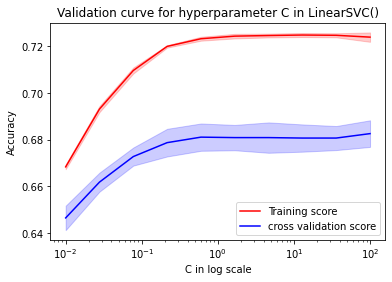

best value for C in LinearSVC() is 100.0


In [168]:
val_curve(param_range, train_scores, valid_scores, LinearSVC())

## rbf SVC

In [169]:
parameters = {
    'kernel': ['rbf'],
    'gamma': [1e-2, 1e-3, 1e-4],
    "C": [10, 100, 1000, 10000],
}

grd = GridSearchCV(estimator=SVC(), param_grid=parameters, n_jobs=-1, cv=3)

grd.fit(*train_tuple)
print(grd.best_params_)
print(grd.best_score_)
print(grd.score(*train_tuple))
print(grd.score(*test_tuple))
print(classification_report(y_train, grd.predict(kbest_train_x_700)))

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.6785924906624731
0.7293755324028569
0.6630484635376853
              precision    recall  f1-score   support

    negative       0.76      0.46      0.57      2616
     neutral       0.71      0.90      0.80      8811
    positive       0.77      0.52      0.62      3834

    accuracy                           0.73     15261
   macro avg       0.75      0.63      0.66     15261
weighted avg       0.74      0.73      0.71     15261



In [170]:
param_range = np.logspace(-2, 3, 10)
train_scores_rbf, valid_scores_rbf = validation_curve(
    SVC(max_iter=10000, kernel="rbf", gamma=0.001),
    kbest_train_x_700,
    y_train,
    param_name='C',
    param_range=param_range,
    cv=3,
    n_jobs=-1,
    verbose=10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   39.1s remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   40.7s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   42.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   42.7s remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.2min remaining:   42.9s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.3min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.3min remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


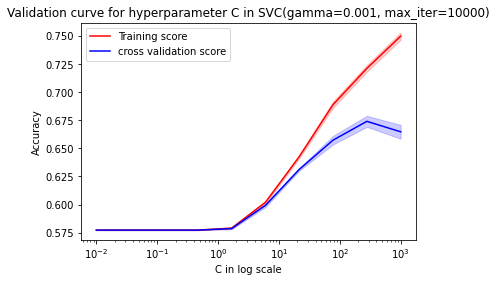

best value for C in SVC(gamma=0.001, max_iter=10000) is 278.2559402207126


In [171]:
val_curve(param_range, train_scores_rbf, valid_scores_rbf,
          SVC(max_iter=10000, kernel="rbf", gamma=0.001))

# Random Forest

In [172]:
# Random Forests

parameters = {
    "n_estimators": [10, 25, 50, 75, 100, 150, 200],
    "max_depth": [10, 25, 50, 75, 100, 150, 200],
    "criterion": ["entropy", "gini"],
}

random_forest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1, n_jobs=-1),
    param_grid=parameters,
    n_jobs=-1,
    cv=3
)

In [173]:
grd.fit(*train_tuple)
print(grd.best_params_)
print(grd.score(*train_tuple))
print(grd.score(*test_tuple))
print(classification_report(y_test, grd.predict(kbest_test_x_700)))

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.7293755324028569
0.6630484635376853
              precision    recall  f1-score   support

    negative       0.55      0.32      0.41      1099
     neutral       0.68      0.85      0.75      3848
    positive       0.68      0.44      0.54      1594

    accuracy                           0.66      6541
   macro avg       0.63      0.54      0.57      6541
weighted avg       0.65      0.66      0.64      6541



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


0.9631741039250377
0.6471487540131479


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


[[ 201  844   54]
 [ 123 3401  324]
 [  11  952  631]]


Text(33.0, 0.5, 'Actual classes')

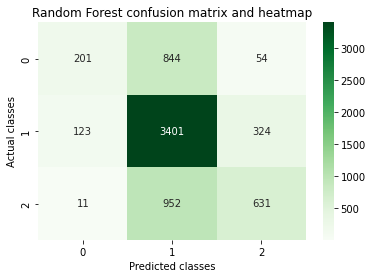

In [174]:
#random forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=1,
                            max_depth=150).fit(
    *train_tuple)
print(rf.score(*train_tuple))
print(rf.score(*test_tuple))

rf_pred = rf.predict(kbest_test_x_700)
matrix_rf = confusion_matrix(y_test, rf_pred)

print(matrix_rf)

sns.heatmap(matrix_rf, cmap='Greens', annot=True, fmt='d')
plt.title("Random Forest confusion matrix and heatmap")
plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

In [175]:
# ada
ada = AdaBoostClassifier().fit(*train_tuple)
print(ada.score(*test_tuple))
print(classification_report(y_test, ada.predict(kbest_test_x_700)))

0.6402690720073383
              precision    recall  f1-score   support

    negative       0.58      0.20      0.30      1099
     neutral       0.64      0.90      0.75      3848
    positive       0.65      0.31      0.42      1594

    accuracy                           0.64      6541
   macro avg       0.62      0.47      0.49      6541
weighted avg       0.63      0.64      0.59      6541



## Logistic Regression

In [176]:
# use grid search find optimal c for logistic regression

param_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
    'multi_class': ['multinomial', 'ovr'],
}

gs_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_lr,
    cv=5,
    n_jobs=1,
    verbose=10
)

print("Performing grid search...")
print("parameters:")
print(param_lr)

gs_lr.fit(*train_tuple)
print(f"Best score: {gs_lr.best_score_}")
print(gs_lr.best_estimator_.get_params())

Performing grid search...
parameters:
{'C': [0.01, 0.1, 0.5, 1, 5, 10, 100], 'multi_class': ['multinomial', 'ovr']}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 1/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.619 total time=   0.2s
[CV 2/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 2/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.619 total time=   0.2s
[CV 3/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 3/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.611 total time=   0.2s
[CV 4/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 4/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.618 total time=   0.2s
[CV 5/5; 1/14] START C=0.01, multi_class=multinomial............................
[CV 5/5; 1/14] END C=0.01, multi_class=multinomial;, score=0.616 total time=   0.2

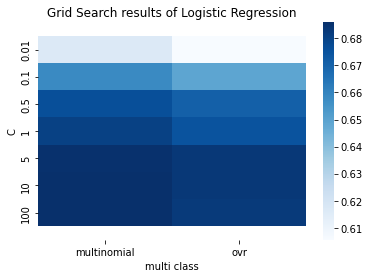

In [177]:
lr_scores = gs_lr.cv_results_['mean_test_score'].reshape(7, 2)

sns.heatmap(
    lr_scores,
    xticklabels=param_lr['multi_class'],
    yticklabels=param_lr['C'],
    cmap='Blues'
)

b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.title("Grid Search results of Logistic Regression")
plt.xlabel("multi class")
plt.ylabel("C")
plt.show()

              precision    recall  f1-score   support

    negative       0.57      0.36      0.44      1099
     neutral       0.68      0.84      0.75      3848
    positive       0.67      0.47      0.55      1594

    accuracy                           0.67      6541
   macro avg       0.64      0.56      0.58      6541
weighted avg       0.66      0.67      0.65      6541



Text(33.0, 0.5, 'Actual classes')

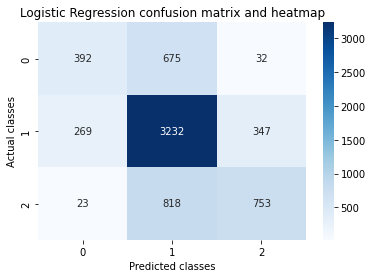

In [178]:
# logistic heatmap
lr_pred = gs_lr.predict(kbest_test_x_700)

matrix_lr = confusion_matrix(y_test, lr_pred)
print(classification_report(y_test, lr_pred))
sns.heatmap(matrix_lr, cmap='Blues', annot=True, fmt='d')
plt.title("Logistic Regression confusion matrix and heatmap")
plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")


### Ensemble models

In [179]:
# voting
base_classifiers = [
    ('sgd', SGDClassifier()),
    ('dt',
     RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=1,
                            max_depth=150)
     ),
    ('lr', LogisticRegression(
        C=10,
        multi_class='multinomial',
        max_iter=1000)
     ),
    ('mnb', MultinomialNB()),

    (' svc', SVC(C=1000, gamma=0.001, kernel='rbf'))
]

voting = VotingClassifier(estimators=base_classifiers, voting='hard')
voting.fit(*train_tuple)
print("voting accuracy")

print(cross_val_score(
    voting,
    *train_tuple, cv=5).mean(),
      voting.score(
          *test_tuple))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


voting accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n

0.683703951895714 0.6758905366151965


In [180]:
# bagging
DT = DecisionTreeClassifier()

bagging_one = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=1.0, max_features=1.0)

bagging_two = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=0.5, max_features=1.0)

bagging_three = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=0.5, max_features=0.5)

DT.fit(*train_tuple)
bagging_one.fit(*train_tuple)
bagging_two.fit(*train_tuple)
bagging_three.fit(*train_tuple)

print("DT:", DT.score(*test_tuple))
print("Option 1: bagging Accuracy:",
      bagging_one.score(*test_tuple))
print("Option 2: bagging Accuracy:",
      bagging_two.score(*test_tuple))
print("Option 3: bagging Accuracy:",
      bagging_three.score(*test_tuple))

DT: 0.5477755694847882
Option 1: bagging Accuracy: 0.594557407124293
Option 2: bagging Accuracy: 0.6162666258981807
Option 3: bagging Accuracy: 0.6135147530958569


# voting

In [181]:
base_classifiers = [
    ('sgd', SGDClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('lr',
     LogisticRegression(
         C=0.5,
         multi_class='multinomial',
         max_iter=1000)
     ),
    ('mnb', MultinomialNB()),
    (' svc', LinearSVC(C=12, max_iter=10000))
]

voting = VotingClassifier(estimators=base_classifiers, voting='hard')
voting.fit(kbest_train_x_500.todense(), y_train_raw)
prediction = voting.predict(kbest_test_x_500.todense())

print(prediction)

['neutral' 'negative' 'neutral' ... 'neutral' 'neutral' 'negative']


In [182]:
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv("voting_prediction_cv.csv")

In [183]:
# stacking code from prac 8
np.random.seed(1)


class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)

    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats

    def predict(self, X):
        X_meta = self._predict_base(X)
        yhat = self.metaclassifier.predict(X_meta)
        return yhat

    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

In [184]:
# base calssifier to be chosen # lr/multinomial
classifiers = [
    LogisticRegression(max_iter=1000),
    MultinomialNB()
]

# three meta classifiers
meta_classifier_lr = LogisticRegression(C=1)
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_mnb = MultinomialNB()
stacker_mnb = StackingClassifier(classifiers, meta_classifier_mnb)

meta_classifier_svc = LinearSVC(C=10)
stacker_svc = StackingClassifier(classifiers, meta_classifier_svc)

In [185]:
start = time.time()
stacker_lr.fit(kbest_train_x_700.todense(), y_train)
end = time.time()

t = end - start
acc_lr = stacker_lr.score(kbest_test_x_700.todense(), y_test)
print('Stacker Accuracy (Logistic Regression)   :', acc_lr, 'Time:', t)

start = time.time()
stacker_mnb.fit(kbest_train_x_700.todense(), y_train)
end = time.time()
t = end - start
acc_mnb = stacker_mnb.score(kbest_test_x_700.todense(), y_test)
print('Stacker Accuracy (Multinomial Regression):', acc_mnb, 'Time:', t)

start = time.time()
stacker_svc.fit(kbest_train_x_700.todense(), y_train)
end = time.time()
t = end - start
acc_svc = stacker_svc.score(kbest_test_x_700.todense(), y_test)
print('Stacker Accuracy (LinearSVC)             :', acc_svc, 'Time:', t)


Stacker Accuracy (Logistic Regression)   : 0.6739030729246293 Time: 5.630630970001221
Stacker Accuracy (Multinomial Regression): 0.6703867910105489 Time: 5.257010221481323
Stacker Accuracy (LinearSVC)             : 0.6726800183458187 Time: 7.898144006729126


### Prediction

In [186]:
stacker_lr.fit(kbest_train_x_500.todense(), y_train_raw)
stacker_svc.fit(kbest_train_x_500.todense(), y_train_raw)

prediction = stacker_svc.predict(kbest_test_x_500.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"svc_stacker_prediction_cv.csv")

prediction = stacker_lr.predict(kbest_test_x_500.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index=test_data['id'])
pre.index.name = 'id'
pre.to_csv(r"lr_stacker_prediction_cv.csv")